Import Libraries dan Membaca Data

In [12]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'shipping_data.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset
data.head()


,name,price ($),weight (kg),length (m),width (m),height (m),shipment date,destination port
0,Camera Bag,37.66,1.10,0.40,0.39,0.26,1970-01-01 07:00:45.004,Port of Singapore (Singapore)
1,Portable Bluetooth Keyboard,144.65,0.39,0.11,0.06,0.03,1970-01-01 07:00:45.006,Port of Busan (South Korea)
2,Large Flat Rate Box,38.57,0.97,0.79,0.55,0.35,1970-01-01 07:00:45.010,Port of Tianjin (China)
3,Ceramic Tiles,10.34,6.22,0.36,0.37,0.02,1970-01-01 07:00:45.000,Port of Shanghai (China)
4,Garden Hose,21.63,1.18,17.77,0.27,0.13,1970-01-01 07:00:45.010,Port of Tianjin (China)


Definisikan Variabel Fuzzy dan Set Fuzzy


In [13]:
# Define the fuzzy variables
weight = ctrl.Antecedent(np.arange(0, 50, 1), 'weight')
length = ctrl.Antecedent(np.arange(0, 5, 0.1), 'length')
width = ctrl.Antecedent(np.arange(0, 5, 0.1), 'width')
height = ctrl.Antecedent(np.arange(0, 5, 0.1), 'height')
price = ctrl.Consequent(np.arange(0, 500, 1), 'price')

# Define fuzzy sets for weight
weight['light'] = fuzz.trimf(weight.universe, [0, 0, 10])
weight['medium'] = fuzz.trimf(weight.universe, [5, 15, 25])
weight['heavy'] = fuzz.trimf(weight.universe, [20, 50, 50])

# Define fuzzy sets for length
length['short'] = fuzz.trimf(length.universe, [0, 0, 1])
length['medium'] = fuzz.trimf(length.universe, [0.5, 1.5, 2.5])
length['long'] = fuzz.trimf(length.universe, [2, 5, 5])

# Define fuzzy sets for width
width['narrow'] = fuzz.trimf(width.universe, [0, 0, 1])
width['medium'] = fuzz.trimf(width.universe, [0.5, 1.5, 2.5])
width['wide'] = fuzz.trimf(width.universe, [2, 5, 5])

# Define fuzzy sets for height
height['short'] = fuzz.trimf(height.universe, [0, 0, 1])
height['medium'] = fuzz.trimf(height.universe, [0.5, 1.5, 2.5])
height['tall'] = fuzz.trimf(height.universe, [2, 5, 5])

# Define fuzzy sets for price
price['cheap'] = fuzz.trimf(price.universe, [0, 0, 100])
price['affordable'] = fuzz.trimf(price.universe, [50, 150, 250])
price['expensive'] = fuzz.trimf(price.universe, [200, 500, 500])


Definisikan Aturan Fuzzy

In [14]:
# Define the fuzzy rules
rule1 = ctrl.Rule(weight['light'] & length['short'] & width['narrow'] & height['short'], price['cheap'])
rule2 = ctrl.Rule(weight['medium'] & length['medium'] & width['medium'] & height['medium'], price['affordable'])
rule3 = ctrl.Rule(weight['heavy'] & length['long'] & width['wide'] & height['tall'], price['expensive'])
rule4 = ctrl.Rule(weight['light'] & (length['medium'] | width['medium'] | height['medium']), price['affordable'])
rule5 = ctrl.Rule(weight['heavy'] & (length['short'] | width['narrow'] | height['short']), price['affordable'])
rule6 = ctrl.Rule(weight['medium'] & (length['long'] | width['wide'] | height['tall']), price['expensive'])

# Adding a default rule to handle sparse conditions
rule_default = ctrl.Rule(weight['light'] | weight['medium'] | weight['heavy'], price['affordable'])

# Create the control system
price_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule_default])
price_sim = ctrl.ControlSystemSimulation(price_ctrl)


Menghitung Harga Berdasarkan Input

In [15]:
# Function to compute price based on inputs
def compute_price(item_weight, item_length, item_width, item_height):
    price_sim.input['weight'] = item_weight
    price_sim.input['length'] = item_length
    price_sim.input['width'] = item_width
    price_sim.input['height'] = item_height
    
    # Compute the output
    price_sim.compute()
    return price_sim.output['price']

# Apply the fuzzy logic system to each row in the DataFrame
prices = []
for index, row in data.iterrows():
    item_weight = row['weight (kg)']
    item_length = row['length (m)']
    item_width = row['width (m)']
    item_height = row['height (m)']
    item_price = compute_price(item_weight, item_length, item_width, item_height)
    prices.append(item_price)

# Add the computed prices to the DataFrame
data['computed_price ($)'] = prices

# Display the first few rows of the updated DataFrame
data.head()


,name,price ($),weight (kg),length (m),width (m),height (m),shipment date,destination port,computed_price ($)
0,Camera Bag,37.66,1.10,0.40,0.39,0.26,1970-01-01 07:00:45.004,Port of Singapore (Singapore),118.252936
1,Portable Bluetooth Keyboard,144.65,0.39,0.11,0.06,0.03,1970-01-01 07:00:45.006,Port of Busan (South Korea),113.102702
2,Large Flat Rate Box,38.57,0.97,0.79,0.55,0.35,1970-01-01 07:00:45.010,Port of Tianjin (China),136.421713
3,Ceramic Tiles,10.34,6.22,0.36,0.37,0.02,1970-01-01 07:00:45.000,Port of Shanghai (China),116.587611
4,Garden Hose,21.63,1.18,17.77,0.27,0.13,1970-01-01 07:00:45.010,Port of Tianjin (China),150.000000


Menyimpan Data yang Diperbarui ke File Excel Baru

In [16]:
# Save the DataFrame to a new Excel file
output_file_path = 'shipping_data_with_prices.xlsx'
data.to_excel(output_file_path, index=False)


Visualisasi Hasil Fuzzy Inference

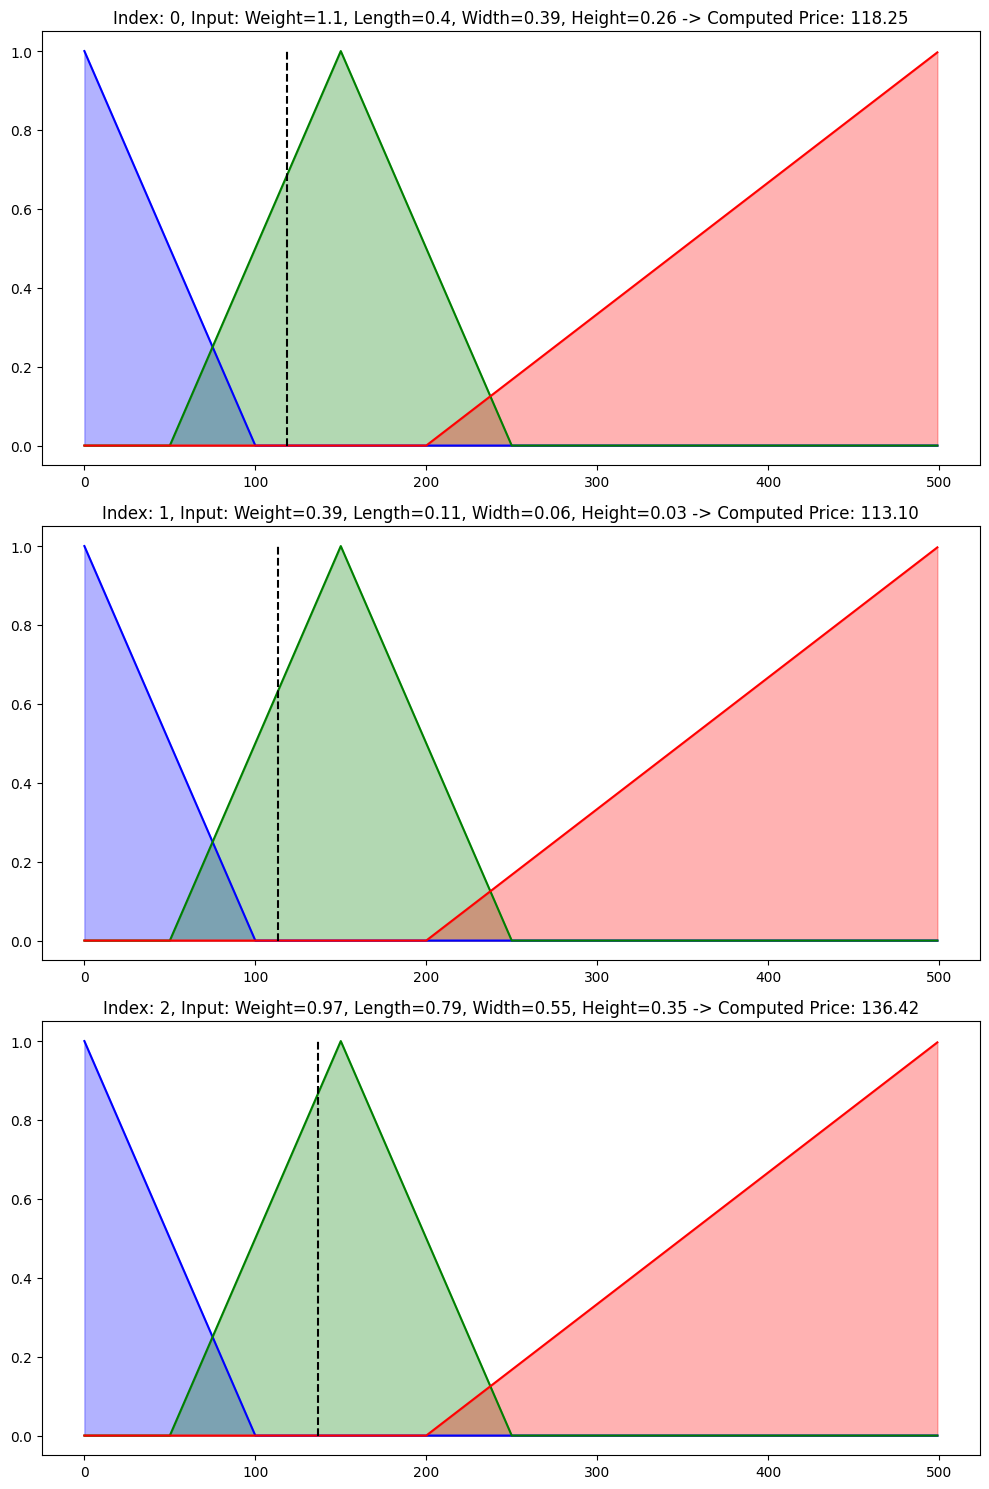

In [17]:
# Select some example rows from the data for visualization
example_indices = [0, 1, 2]  # Choose indices of rows to visualize
example_inputs = data.iloc[example_indices]

fig, axs = plt.subplots(nrows=len(example_inputs), figsize=(10, 15))

for i, (index, row) in enumerate(example_inputs.iterrows()):
    price_sim.input['weight'] = row['weight (kg)']
    price_sim.input['length'] = row['length (m)']
    price_sim.input['width'] = row['width (m)']
    price_sim.input['height'] = row['height (m)']
    
    # Compute the output
    price_sim.compute()
    
    # Extract the membership functions for the price
    price_mf_cheap = fuzz.trimf(price.universe, [0, 0, 100])
    price_mf_affordable = fuzz.trimf(price.universe, [50, 150, 250])
    price_mf_expensive = fuzz.trimf(price.universe, [200, 500, 500])
    
    # Plot the result
    axs[i].plot(price.universe, price_mf_cheap, 'b', linewidth=1.5, label='Cheap')
    axs[i].plot(price.universe, price_mf_affordable, 'g', linewidth=1.5, label='Affordable')
    axs[i].plot(price.universe, price_mf_expensive, 'r', linewidth=1.5, label='Expensive')
    axs[i].fill_between(price.universe, 0, price_mf_cheap, alpha=0.3, color='b')
    axs[i].fill_between(price.universe, 0, price_mf_affordable, alpha=0.3, color='g')
    axs[i].fill_between(price.universe, 0, price_mf_expensive, alpha=0.3, color='r')
    axs[i].plot([price_sim.output['price'], price_sim.output['price']], [0, 1], 'k', linewidth=1.5, linestyle='--')
    axs[i].set_title(f"Index: {index}, Input: Weight={row['weight (kg)']}, Length={row['length (m)']}, Width={row['width (m)']}, Height={row['height (m)']} -> Computed Price: {price_sim.output['price']:.2f}")

plt.tight_layout()
plt.show()
